In [127]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

x_train_text = pd.read_csv('data/t2e/text_train.csv')
x_test_text = pd.read_csv('data/t2e/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('data/s2e/audio_train.csv')
x_test_audio = pd.read_csv('data/s2e/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio 
y_test = y_test_audio  

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(7837, 3) (7837,) (7837, 10) (7837,)


In [128]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [129]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## 文本特征

In [130]:
# 使用 concat 来合并两个 DataFrame 的 transcription 列
combined_text = pd.concat([x_train_text['transcription'], x_test_text['transcription']])

# 初始化 TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# 使用合并后的文本数据来拟合和转换 TfidfVectorizer
features_text = tfidf.fit_transform(combined_text).toarray()

# 根据原始训练和测试集的大小来分割特征
x_train_text = features_text[:x_train_text.shape[0], :]
x_test_text = features_text[-x_test_text.shape[0]:, :]

# 打印形状信息
print(features_text.shape, x_train_text.shape, x_test_text.shape)

(9797, 2464) (7837, 2464) (1960, 2464)


## 特征融合

In [131]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

with open('data/combined/combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)


(7837, 2472) (1960, 2472)


In [132]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# 预测
pred_probs = rf_classifier.predict_proba(combined_x_test)

# 结果
y_pred = pred_probs.argmax(axis=1)

one_hot_true = one_hot_encoder(y_test, len(y_pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, y_pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, y_pred, average='macro')))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 输出混淆矩阵的数值
print("Confusion matrix")
print(cm)

# 保存
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)


Test Set Accuracy =  0.666
Test Set F-score =  0.666
Test Set Precision =  0.720
Test Set Recall =  0.660
Confusion matrix
[[ 90  18 106   0   3   7]
 [ 18 128 113   3   5  33]
 [ 19  28 496   1   6  33]
 [  0   0   0 247   0   0]
 [  0   0   0   0 241   0]
 [ 13  18 222   4   5 103]]


In [133]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# 预测
pred = svc_classifier.predict(combined_x_test)

# 结果
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))

# 计算混淆矩阵
cm = confusion_matrix(y_test, pred)

# 输出混淆矩阵的数值
print("Confusion matrix")
print(cm)

# 保存
with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    

Test Set Accuracy =  0.649
Test Set F-score =  0.662
Test Set Precision =  0.664
Test Set Recall =  0.666
Confusion matrix
[[125   7  64   7   5  16]
 [  8 190  36   8  11  47]
 [ 42  33 392  16  24  76]
 [  0   0  15 232   0   0]
 [  1   3  25  14 198   0]
 [ 20  48 135  14  12 136]]


In [134]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# 预测
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# 结果
y_pred = pred_probs.argmax(axis=1)

one_hot_true = one_hot_encoder(y_test, len(y_pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, y_pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, y_pred, average='macro')))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 输出混淆矩阵的数值
print("Confusion matrix")
print(cm)

# 保存
with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)


Test Set Accuracy =  0.607
Test Set F-score =  0.608
Test Set Precision =  0.719
Test Set Recall =  0.574
Confusion matrix
[[ 88  13 107   3   5   8]
 [  4 166  94   3   8  25]
 [ 18  20 509   3   9  24]
 [  0   0  70 177   0   0]
 [  0   8  74   0 159   0]
 [  4  30 224   9   7  91]]


In [135]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# 预测
pred_probs = lr_classifier.predict_proba(combined_x_test)

# 结果
y_pred = pred_probs.argmax(axis=1)

one_hot_true = one_hot_encoder(y_test, len(y_pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, y_pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, y_pred, average='macro')))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 输出混淆矩阵的数值
print("Confusion matrix")
print(cm)

# 保存
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)


D:\Ide\Anaconda\envs\MER\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Accuracy =  0.631
Test Set F-score =  0.643
Test Set Precision =  0.686
Test Set Recall =  0.620
Confusion matrix
[[119   8  77   1   5  14]
 [  9 175  59   4  13  40]
 [ 28  29 449   4  18  55]
 [ 10   0  53 184   0   0]
 [  5   7  49   2 173   5]
 [  7  34 166   9  12 137]]


Test Set Accuracy =  0.696
Test Set F-score =  0.699
Test Set Precision =  0.751
Test Set Recall =  0.691
Confusion matrix, without normalization
[[ 97   8 102   2   6   9]
 [  7 172  74   3   9  35]
 [ 21  19 501   2   9  31]
 [  0   0   0 247   0   0]
 [  0   0   8   0 233   0]
 [  5  27 205   7   6 115]]


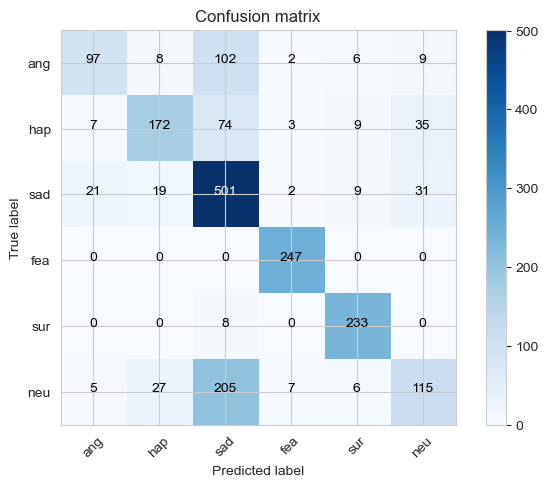

In [140]:
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)


# 平均
ensemble_pred_probs = (rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/3.0
# 混淆矩阵
display_results(y_test, ensemble_pred_probs)